# Soft Attention MNIST

This is jupyter notebook for `Soft Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). This modified MNIST dataset is good for verifying attention algorithm.

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random

In [2]:
# Import MNIST data

mat_data_train = scipy.io.loadmat('MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('MNIST_data_test_re.mat')

train_x = mat_data_train['X_train']
train_y = mat_data_train['Y_train']

test_x = mat_data_test['X_test'][:9900, :]
test_y = mat_data_test['Y_test'][:9900, :]

validation_x = mat_data_test['X_test'][9900:, :]
validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print("Validation data shape: " + str(validation_x.shape))
print("Validation label shape: " + str(validation_y.shape))

Train data shape: (55000, 112, 112)
Train label shape: (55000, 10)
Test data shape: (9900, 112, 112)
Test label shape: (9900, 10)
Validation data shape: (100, 112, 112)
Validation label shape: (100, 10)


## Parameters

In [3]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_name = '1'

# Numbers of sampling to test the code 
num_test_sample = 10

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.5

# parameter for attention
img_fraction_size = 28
stride = 14

len_horizontal = int((img_size - img_fraction_size) / stride + 1)
len_vertical   = int((img_size - img_fraction_size) / stride + 1)
len_stack = len_horizontal * len_vertical

print("Horizontal Length: " + str(len_horizontal))
print("Vertical Length: " +str(len_vertical))
print("Window Length: " +str(len_stack))

Horizontal Length: 7
Vertical Length: 7
Window Length: 49


## Plotting Sample Image (Modified MNIST for Attention)

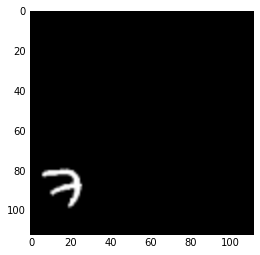

Label: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [4]:
# Plotting example image
img = train_x[0, :, :]
# img_resize = img.reshape((img_size, img_size))
plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))

## Plotting Sample Image Fractions

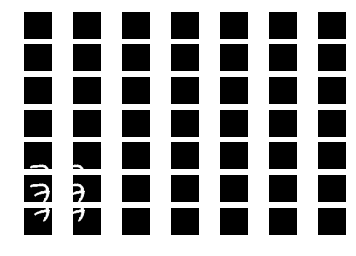

In [5]:
f, ax = plt.subplots(len_vertical, len_horizontal)

img_fraction = np.zeros([img_fraction_size, img_fraction_size, len_stack])
index_fraction = 0
for i in range(len_vertical):
    start_v = stride * i
    for j in range(len_horizontal):
        start_h = stride * j
                
        img_fraction[:,:,index_fraction] = img[start_v : start_v + img_fraction_size, 
                                               start_h : start_h + img_fraction_size]
        
        ax[i, j].imshow(img_fraction[:,:,index_fraction], cmap = 'gray')
        ax[i, j].axis('off')
        
        index_fraction += 1
        
plt.show()

In [6]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [7]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Soft Attention function
def soft_attention(h_prev, a, Wa):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Image windows after CNN. List of convolution window images 
    # (List len: number of windows, element shape: [batch_size, convolution flatten size])
    
    m_list = [tf.tanh(tf.matmul(tf.concat([h_prev, a[i]], axis = 1), Wa)) for i in range(len(a))]
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)
    alpha = tf.nn.softmax(m_concat)
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)
    return alpha, z
    

## Network

In [8]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_fraction_size, img_fraction_size, len_stack])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

x_unstack = tf.unstack(x_image, axis = 3)

# Convolution variables
w_conv1 = weight_variable('W_conv1', [5, 5, 1, 32])
b_conv1 = bias_variable('b_conv1', [32])
w_conv2 = weight_variable('W_conv2', [1, 1, 32, 16])
b_conv2 = bias_variable('b_conv2', [16])

conv_list = []
for i in range(len_stack):
    x_conv = tf.reshape(x_unstack[i], (-1, img_fraction_size, img_fraction_size, 1))
    conv1 = tf.nn.relu(conv2d(x_conv, w_conv1, 2) + b_conv1)
    pool1 = max_pool_2x2(conv1)
    conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 1) + b_conv2)
    pool2 = max_pool_2x2(conv2)
    conv_result_flat = tf.contrib.layers.flatten(pool2)
    conv_list.append(conv_result_flat)

len_conv = int(conv_list[0].get_shape()[1])

#LSTM Variables
Wf = weight_variable('Wf', [len_conv + lstm_size, lstm_size])
Wi = weight_variable('Wi', [len_conv + lstm_size, lstm_size])
Wc = weight_variable('Wc', [len_conv + lstm_size, lstm_size])
Wo = weight_variable('Wo', [len_conv + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [lstm_size + len_conv, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = soft_attention(rnn_out, conv_list, Wa)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create Session

In [9]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [10]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state("saved_networks/")
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [11]:
# Training

if Is_train == True:
    train_data_num = train_x.shape[0]

    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]


            # Make image as fractions for attention
            train_fraction = np.zeros([batch_x_train.shape[0], img_fraction_size, img_fraction_size, len_stack])
            validation_fraction = np.zeros([validation_x.shape[0], img_fraction_size, img_fraction_size, len_stack])

            index_fraction = 0
            for m in range(len_vertical):
                start_v = stride * m
                for n in range(len_horizontal):
                    start_h = stride * n

                    train_fraction[:,:,:,index_fraction] = batch_x_train[:, 
                                                                         start_v : start_v + img_fraction_size, 
                                                                         start_h : start_h + img_fraction_size]

                    validation_fraction[:,:,:,index_fraction] = validation_x[:, 
                                                                            start_v : start_v + img_fraction_size, 
                                                                            start_h : start_h + img_fraction_size]
                    index_fraction += 1

            # Training
            optimizer.run(feed_dict = {x_image: train_fraction, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_fraction, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_fraction, y_target: batch_y_train})
            val_acc = sess.run(accuracy, feed_dict = {x_image: validation_fraction, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc) + ' / ' + 
                  "Validation Accuracy: " + str(val_acc))  

        saver.save(sess, 'saved_networks/' + save_name)
        print('Model is saved!!!')

Epoch: 1 / Batch: 0/55000 / Cost: 0.59822 / Training Accuracy: 0.0820312 / Validation Accuracy: 0.06
Epoch: 1 / Batch: 256/55000 / Cost: 0.556034 / Training Accuracy: 0.0703125 / Validation Accuracy: 0.06
Epoch: 1 / Batch: 512/55000 / Cost: 0.513444 / Training Accuracy: 0.0898438 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 768/55000 / Cost: 0.47305 / Training Accuracy: 0.113281 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 1024/55000 / Cost: 0.43887 / Training Accuracy: 0.109375 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 1280/55000 / Cost: 0.402899 / Training Accuracy: 0.101562 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 1536/55000 / Cost: 0.374652 / Training Accuracy: 0.0976562 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 1792/55000 / Cost: 0.349168 / Training Accuracy: 0.113281 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 2048/55000 / Cost: 0.33647 / Training Accuracy: 0.0976562 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 2304/55000 / Cost: 0.327807 / Training Accuracy: 0.

Epoch: 1 / Batch: 20224/55000 / Cost: 0.32568 / Training Accuracy: 0.109375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20480/55000 / Cost: 0.324075 / Training Accuracy: 0.109375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20736/55000 / Cost: 0.324669 / Training Accuracy: 0.09375 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 20992/55000 / Cost: 0.325614 / Training Accuracy: 0.0820312 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 21248/55000 / Cost: 0.324216 / Training Accuracy: 0.1875 / Validation Accuracy: 0.18
Epoch: 1 / Batch: 21504/55000 / Cost: 0.325419 / Training Accuracy: 0.0703125 / Validation Accuracy: 0.09
Epoch: 1 / Batch: 21760/55000 / Cost: 0.32508 / Training Accuracy: 0.144531 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 22016/55000 / Cost: 0.324778 / Training Accuracy: 0.125 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 22272/55000 / Cost: 0.324418 / Training Accuracy: 0.160156 / Validation Accuracy: 0.12
Epoch: 1 / Batch: 22528/55000 / Cost: 0.32463 / Training Accu

Epoch: 1 / Batch: 40448/55000 / Cost: 0.303533 / Training Accuracy: 0.179688 / Validation Accuracy: 0.24
Epoch: 1 / Batch: 40704/55000 / Cost: 0.312688 / Training Accuracy: 0.167969 / Validation Accuracy: 0.26
Epoch: 1 / Batch: 40960/55000 / Cost: 0.309529 / Training Accuracy: 0.164062 / Validation Accuracy: 0.26
Epoch: 1 / Batch: 41216/55000 / Cost: 0.303984 / Training Accuracy: 0.226562 / Validation Accuracy: 0.26
Epoch: 1 / Batch: 41472/55000 / Cost: 0.308787 / Training Accuracy: 0.183594 / Validation Accuracy: 0.25
Epoch: 1 / Batch: 41728/55000 / Cost: 0.311859 / Training Accuracy: 0.191406 / Validation Accuracy: 0.21
Epoch: 1 / Batch: 41984/55000 / Cost: 0.299838 / Training Accuracy: 0.257812 / Validation Accuracy: 0.23
Epoch: 1 / Batch: 42240/55000 / Cost: 0.300017 / Training Accuracy: 0.226562 / Validation Accuracy: 0.23
Epoch: 1 / Batch: 42496/55000 / Cost: 0.303196 / Training Accuracy: 0.214844 / Validation Accuracy: 0.23
Epoch: 1 / Batch: 42752/55000 / Cost: 0.309151 / Traini

Epoch: 2 / Batch: 5632/55000 / Cost: 0.296033 / Training Accuracy: 0.226562 / Validation Accuracy: 0.23
Epoch: 2 / Batch: 5888/55000 / Cost: 0.300476 / Training Accuracy: 0.230469 / Validation Accuracy: 0.25
Epoch: 2 / Batch: 6144/55000 / Cost: 0.30248 / Training Accuracy: 0.222656 / Validation Accuracy: 0.28
Epoch: 2 / Batch: 6400/55000 / Cost: 0.297679 / Training Accuracy: 0.207031 / Validation Accuracy: 0.28
Epoch: 2 / Batch: 6656/55000 / Cost: 0.298947 / Training Accuracy: 0.222656 / Validation Accuracy: 0.27
Epoch: 2 / Batch: 6912/55000 / Cost: 0.285773 / Training Accuracy: 0.277344 / Validation Accuracy: 0.3
Epoch: 2 / Batch: 7168/55000 / Cost: 0.292915 / Training Accuracy: 0.242188 / Validation Accuracy: 0.28
Epoch: 2 / Batch: 7424/55000 / Cost: 0.292365 / Training Accuracy: 0.28125 / Validation Accuracy: 0.26
Epoch: 2 / Batch: 7680/55000 / Cost: 0.299283 / Training Accuracy: 0.210938 / Validation Accuracy: 0.26
Epoch: 2 / Batch: 7936/55000 / Cost: 0.289018 / Training Accuracy: 

Epoch: 2 / Batch: 25856/55000 / Cost: 0.263419 / Training Accuracy: 0.324219 / Validation Accuracy: 0.31
Epoch: 2 / Batch: 26112/55000 / Cost: 0.258209 / Training Accuracy: 0.324219 / Validation Accuracy: 0.29
Epoch: 2 / Batch: 26368/55000 / Cost: 0.270191 / Training Accuracy: 0.304688 / Validation Accuracy: 0.31
Epoch: 2 / Batch: 26624/55000 / Cost: 0.272288 / Training Accuracy: 0.28125 / Validation Accuracy: 0.3
Epoch: 2 / Batch: 26880/55000 / Cost: 0.266985 / Training Accuracy: 0.308594 / Validation Accuracy: 0.33
Epoch: 2 / Batch: 27136/55000 / Cost: 0.265656 / Training Accuracy: 0.332031 / Validation Accuracy: 0.34
Epoch: 2 / Batch: 27392/55000 / Cost: 0.258707 / Training Accuracy: 0.359375 / Validation Accuracy: 0.33
Epoch: 2 / Batch: 27648/55000 / Cost: 0.269175 / Training Accuracy: 0.316406 / Validation Accuracy: 0.32
Epoch: 2 / Batch: 27904/55000 / Cost: 0.271623 / Training Accuracy: 0.296875 / Validation Accuracy: 0.31
Epoch: 2 / Batch: 28160/55000 / Cost: 0.273579 / Training

Epoch: 2 / Batch: 46080/55000 / Cost: 0.235779 / Training Accuracy: 0.425781 / Validation Accuracy: 0.38
Epoch: 2 / Batch: 46336/55000 / Cost: 0.24172 / Training Accuracy: 0.386719 / Validation Accuracy: 0.44
Epoch: 2 / Batch: 46592/55000 / Cost: 0.240247 / Training Accuracy: 0.398438 / Validation Accuracy: 0.46
Epoch: 2 / Batch: 46848/55000 / Cost: 0.221809 / Training Accuracy: 0.515625 / Validation Accuracy: 0.43
Epoch: 2 / Batch: 47104/55000 / Cost: 0.2495 / Training Accuracy: 0.371094 / Validation Accuracy: 0.44
Epoch: 2 / Batch: 47360/55000 / Cost: 0.256089 / Training Accuracy: 0.332031 / Validation Accuracy: 0.44
Epoch: 2 / Batch: 47616/55000 / Cost: 0.231673 / Training Accuracy: 0.445312 / Validation Accuracy: 0.45
Epoch: 2 / Batch: 47872/55000 / Cost: 0.229271 / Training Accuracy: 0.453125 / Validation Accuracy: 0.42
Epoch: 2 / Batch: 48128/55000 / Cost: 0.239621 / Training Accuracy: 0.414062 / Validation Accuracy: 0.44
Epoch: 2 / Batch: 48384/55000 / Cost: 0.222568 / Training 

Epoch: 3 / Batch: 11264/55000 / Cost: 0.215038 / Training Accuracy: 0.480469 / Validation Accuracy: 0.58
Epoch: 3 / Batch: 11520/55000 / Cost: 0.214398 / Training Accuracy: 0.542969 / Validation Accuracy: 0.5
Epoch: 3 / Batch: 11776/55000 / Cost: 0.212003 / Training Accuracy: 0.492188 / Validation Accuracy: 0.48
Epoch: 3 / Batch: 12032/55000 / Cost: 0.201648 / Training Accuracy: 0.496094 / Validation Accuracy: 0.58
Epoch: 3 / Batch: 12288/55000 / Cost: 0.219362 / Training Accuracy: 0.460938 / Validation Accuracy: 0.62
Epoch: 3 / Batch: 12544/55000 / Cost: 0.211043 / Training Accuracy: 0.496094 / Validation Accuracy: 0.52
Epoch: 3 / Batch: 12800/55000 / Cost: 0.208052 / Training Accuracy: 0.523438 / Validation Accuracy: 0.43
Epoch: 3 / Batch: 13056/55000 / Cost: 0.211847 / Training Accuracy: 0.472656 / Validation Accuracy: 0.52
Epoch: 3 / Batch: 13312/55000 / Cost: 0.207104 / Training Accuracy: 0.472656 / Validation Accuracy: 0.54
Epoch: 3 / Batch: 13568/55000 / Cost: 0.194042 / Trainin

Epoch: 3 / Batch: 31488/55000 / Cost: 0.173027 / Training Accuracy: 0.636719 / Validation Accuracy: 0.61
Epoch: 3 / Batch: 31744/55000 / Cost: 0.185853 / Training Accuracy: 0.59375 / Validation Accuracy: 0.6
Epoch: 3 / Batch: 32000/55000 / Cost: 0.176299 / Training Accuracy: 0.632812 / Validation Accuracy: 0.61
Epoch: 3 / Batch: 32256/55000 / Cost: 0.181362 / Training Accuracy: 0.617188 / Validation Accuracy: 0.61
Epoch: 3 / Batch: 32512/55000 / Cost: 0.190339 / Training Accuracy: 0.539062 / Validation Accuracy: 0.59
Epoch: 3 / Batch: 32768/55000 / Cost: 0.175237 / Training Accuracy: 0.605469 / Validation Accuracy: 0.59
Epoch: 3 / Batch: 33024/55000 / Cost: 0.168438 / Training Accuracy: 0.644531 / Validation Accuracy: 0.64
Epoch: 3 / Batch: 33280/55000 / Cost: 0.171958 / Training Accuracy: 0.597656 / Validation Accuracy: 0.59
Epoch: 3 / Batch: 33536/55000 / Cost: 0.183288 / Training Accuracy: 0.597656 / Validation Accuracy: 0.59
Epoch: 3 / Batch: 33792/55000 / Cost: 0.171541 / Training

Epoch: 3 / Batch: 51712/55000 / Cost: 0.164226 / Training Accuracy: 0.625 / Validation Accuracy: 0.7
Epoch: 3 / Batch: 51968/55000 / Cost: 0.153082 / Training Accuracy: 0.703125 / Validation Accuracy: 0.71
Epoch: 3 / Batch: 52224/55000 / Cost: 0.151491 / Training Accuracy: 0.707031 / Validation Accuracy: 0.68
Epoch: 3 / Batch: 52480/55000 / Cost: 0.158945 / Training Accuracy: 0.664062 / Validation Accuracy: 0.62
Epoch: 3 / Batch: 52736/55000 / Cost: 0.152104 / Training Accuracy: 0.691406 / Validation Accuracy: 0.64
Epoch: 3 / Batch: 52992/55000 / Cost: 0.144119 / Training Accuracy: 0.699219 / Validation Accuracy: 0.67
Epoch: 3 / Batch: 53248/55000 / Cost: 0.151017 / Training Accuracy: 0.660156 / Validation Accuracy: 0.68
Epoch: 3 / Batch: 53504/55000 / Cost: 0.147629 / Training Accuracy: 0.683594 / Validation Accuracy: 0.63
Epoch: 3 / Batch: 53760/55000 / Cost: 0.15901 / Training Accuracy: 0.628906 / Validation Accuracy: 0.57
Epoch: 3 / Batch: 54016/55000 / Cost: 0.164992 / Training Ac

Epoch: 4 / Batch: 16896/55000 / Cost: 0.140622 / Training Accuracy: 0.722656 / Validation Accuracy: 0.74
Epoch: 4 / Batch: 17152/55000 / Cost: 0.147739 / Training Accuracy: 0.707031 / Validation Accuracy: 0.7
Epoch: 4 / Batch: 17408/55000 / Cost: 0.132305 / Training Accuracy: 0.765625 / Validation Accuracy: 0.71
Epoch: 4 / Batch: 17664/55000 / Cost: 0.1259 / Training Accuracy: 0.734375 / Validation Accuracy: 0.65
Epoch: 4 / Batch: 17920/55000 / Cost: 0.131338 / Training Accuracy: 0.734375 / Validation Accuracy: 0.73
Epoch: 4 / Batch: 18176/55000 / Cost: 0.131892 / Training Accuracy: 0.773438 / Validation Accuracy: 0.73
Epoch: 4 / Batch: 18432/55000 / Cost: 0.139588 / Training Accuracy: 0.722656 / Validation Accuracy: 0.69
Epoch: 4 / Batch: 18688/55000 / Cost: 0.13361 / Training Accuracy: 0.742188 / Validation Accuracy: 0.72
Epoch: 4 / Batch: 18944/55000 / Cost: 0.13561 / Training Accuracy: 0.746094 / Validation Accuracy: 0.77
Epoch: 4 / Batch: 19200/55000 / Cost: 0.131248 / Training Ac

Epoch: 4 / Batch: 37120/55000 / Cost: 0.122841 / Training Accuracy: 0.757812 / Validation Accuracy: 0.79
Epoch: 4 / Batch: 37376/55000 / Cost: 0.116296 / Training Accuracy: 0.78125 / Validation Accuracy: 0.78
Epoch: 4 / Batch: 37632/55000 / Cost: 0.11813 / Training Accuracy: 0.765625 / Validation Accuracy: 0.78
Epoch: 4 / Batch: 37888/55000 / Cost: 0.120014 / Training Accuracy: 0.785156 / Validation Accuracy: 0.8
Epoch: 4 / Batch: 38144/55000 / Cost: 0.119293 / Training Accuracy: 0.78125 / Validation Accuracy: 0.77
Epoch: 4 / Batch: 38400/55000 / Cost: 0.128112 / Training Accuracy: 0.742188 / Validation Accuracy: 0.76
Epoch: 4 / Batch: 38656/55000 / Cost: 0.13468 / Training Accuracy: 0.734375 / Validation Accuracy: 0.78
Epoch: 4 / Batch: 38912/55000 / Cost: 0.125981 / Training Accuracy: 0.777344 / Validation Accuracy: 0.78
Epoch: 4 / Batch: 39168/55000 / Cost: 0.113128 / Training Accuracy: 0.773438 / Validation Accuracy: 0.8
Epoch: 4 / Batch: 39424/55000 / Cost: 0.116151 / Training Acc

Epoch: 5 / Batch: 2304/55000 / Cost: 0.10229 / Training Accuracy: 0.800781 / Validation Accuracy: 0.8
Epoch: 5 / Batch: 2560/55000 / Cost: 0.108523 / Training Accuracy: 0.78125 / Validation Accuracy: 0.81
Epoch: 5 / Batch: 2816/55000 / Cost: 0.126255 / Training Accuracy: 0.746094 / Validation Accuracy: 0.79
Epoch: 5 / Batch: 3072/55000 / Cost: 0.0970266 / Training Accuracy: 0.835938 / Validation Accuracy: 0.76
Epoch: 5 / Batch: 3328/55000 / Cost: 0.100149 / Training Accuracy: 0.8125 / Validation Accuracy: 0.76
Epoch: 5 / Batch: 3584/55000 / Cost: 0.116076 / Training Accuracy: 0.785156 / Validation Accuracy: 0.77
Epoch: 5 / Batch: 3840/55000 / Cost: 0.0925292 / Training Accuracy: 0.832031 / Validation Accuracy: 0.81
Epoch: 5 / Batch: 4096/55000 / Cost: 0.115378 / Training Accuracy: 0.777344 / Validation Accuracy: 0.82
Epoch: 5 / Batch: 4352/55000 / Cost: 0.112942 / Training Accuracy: 0.777344 / Validation Accuracy: 0.83
Epoch: 5 / Batch: 4608/55000 / Cost: 0.104303 / Training Accuracy: 

Epoch: 5 / Batch: 22528/55000 / Cost: 0.0967297 / Training Accuracy: 0.824219 / Validation Accuracy: 0.85
Epoch: 5 / Batch: 22784/55000 / Cost: 0.092807 / Training Accuracy: 0.84375 / Validation Accuracy: 0.86
Epoch: 5 / Batch: 23040/55000 / Cost: 0.0920553 / Training Accuracy: 0.824219 / Validation Accuracy: 0.87
Epoch: 5 / Batch: 23296/55000 / Cost: 0.10269 / Training Accuracy: 0.84375 / Validation Accuracy: 0.82
Epoch: 5 / Batch: 23552/55000 / Cost: 0.0997715 / Training Accuracy: 0.8125 / Validation Accuracy: 0.85
Epoch: 5 / Batch: 23808/55000 / Cost: 0.0938786 / Training Accuracy: 0.816406 / Validation Accuracy: 0.82
Epoch: 5 / Batch: 24064/55000 / Cost: 0.101839 / Training Accuracy: 0.804688 / Validation Accuracy: 0.82
Epoch: 5 / Batch: 24320/55000 / Cost: 0.104255 / Training Accuracy: 0.8125 / Validation Accuracy: 0.84
Epoch: 5 / Batch: 24576/55000 / Cost: 0.0953593 / Training Accuracy: 0.839844 / Validation Accuracy: 0.83
Epoch: 5 / Batch: 24832/55000 / Cost: 0.0992061 / Trainin

Epoch: 5 / Batch: 42496/55000 / Cost: 0.0785472 / Training Accuracy: 0.84375 / Validation Accuracy: 0.82
Epoch: 5 / Batch: 42752/55000 / Cost: 0.0867064 / Training Accuracy: 0.84375 / Validation Accuracy: 0.85
Epoch: 5 / Batch: 43008/55000 / Cost: 0.0904455 / Training Accuracy: 0.820312 / Validation Accuracy: 0.86
Epoch: 5 / Batch: 43264/55000 / Cost: 0.0901822 / Training Accuracy: 0.835938 / Validation Accuracy: 0.86
Epoch: 5 / Batch: 43520/55000 / Cost: 0.0889455 / Training Accuracy: 0.84375 / Validation Accuracy: 0.88
Epoch: 5 / Batch: 43776/55000 / Cost: 0.0762484 / Training Accuracy: 0.890625 / Validation Accuracy: 0.85
Epoch: 5 / Batch: 44032/55000 / Cost: 0.0910646 / Training Accuracy: 0.832031 / Validation Accuracy: 0.83
Epoch: 5 / Batch: 44288/55000 / Cost: 0.0956053 / Training Accuracy: 0.816406 / Validation Accuracy: 0.86
Epoch: 5 / Batch: 44544/55000 / Cost: 0.094965 / Training Accuracy: 0.816406 / Validation Accuracy: 0.88
Epoch: 5 / Batch: 44800/55000 / Cost: 0.0966653 / 

Epoch: 6 / Batch: 7424/55000 / Cost: 0.0700602 / Training Accuracy: 0.894531 / Validation Accuracy: 0.88
Epoch: 6 / Batch: 7680/55000 / Cost: 0.0977535 / Training Accuracy: 0.808594 / Validation Accuracy: 0.87
Epoch: 6 / Batch: 7936/55000 / Cost: 0.0756184 / Training Accuracy: 0.871094 / Validation Accuracy: 0.9
Epoch: 6 / Batch: 8192/55000 / Cost: 0.0820875 / Training Accuracy: 0.847656 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 8448/55000 / Cost: 0.0816666 / Training Accuracy: 0.84375 / Validation Accuracy: 0.9
Epoch: 6 / Batch: 8704/55000 / Cost: 0.0600727 / Training Accuracy: 0.917969 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 8960/55000 / Cost: 0.0842979 / Training Accuracy: 0.835938 / Validation Accuracy: 0.87
Epoch: 6 / Batch: 9216/55000 / Cost: 0.0646816 / Training Accuracy: 0.902344 / Validation Accuracy: 0.86
Epoch: 6 / Batch: 9472/55000 / Cost: 0.081513 / Training Accuracy: 0.847656 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 9728/55000 / Cost: 0.0770095 / Training A

Epoch: 6 / Batch: 27392/55000 / Cost: 0.0760343 / Training Accuracy: 0.855469 / Validation Accuracy: 0.9
Epoch: 6 / Batch: 27648/55000 / Cost: 0.0896273 / Training Accuracy: 0.824219 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 27904/55000 / Cost: 0.0640936 / Training Accuracy: 0.886719 / Validation Accuracy: 0.91
Epoch: 6 / Batch: 28160/55000 / Cost: 0.0715417 / Training Accuracy: 0.863281 / Validation Accuracy: 0.9
Epoch: 6 / Batch: 28416/55000 / Cost: 0.0731157 / Training Accuracy: 0.886719 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 28672/55000 / Cost: 0.0755334 / Training Accuracy: 0.871094 / Validation Accuracy: 0.86
Epoch: 6 / Batch: 28928/55000 / Cost: 0.0715392 / Training Accuracy: 0.871094 / Validation Accuracy: 0.85
Epoch: 6 / Batch: 29184/55000 / Cost: 0.0770885 / Training Accuracy: 0.855469 / Validation Accuracy: 0.87
Epoch: 6 / Batch: 29440/55000 / Cost: 0.073666 / Training Accuracy: 0.863281 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 29696/55000 / Cost: 0.0723021 /

Epoch: 6 / Batch: 47360/55000 / Cost: 0.0748268 / Training Accuracy: 0.867188 / Validation Accuracy: 0.84
Epoch: 6 / Batch: 47616/55000 / Cost: 0.071333 / Training Accuracy: 0.886719 / Validation Accuracy: 0.88
Epoch: 6 / Batch: 47872/55000 / Cost: 0.0621595 / Training Accuracy: 0.894531 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 48128/55000 / Cost: 0.0797884 / Training Accuracy: 0.847656 / Validation Accuracy: 0.87
Epoch: 6 / Batch: 48384/55000 / Cost: 0.0865023 / Training Accuracy: 0.859375 / Validation Accuracy: 0.86
Epoch: 6 / Batch: 48640/55000 / Cost: 0.0761282 / Training Accuracy: 0.867188 / Validation Accuracy: 0.87
Epoch: 6 / Batch: 48896/55000 / Cost: 0.0737622 / Training Accuracy: 0.871094 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 49152/55000 / Cost: 0.0654174 / Training Accuracy: 0.878906 / Validation Accuracy: 0.89
Epoch: 6 / Batch: 49408/55000 / Cost: 0.0786002 / Training Accuracy: 0.867188 / Validation Accuracy: 0.86
Epoch: 6 / Batch: 49664/55000 / Cost: 0.0705767

Epoch: 7 / Batch: 12288/55000 / Cost: 0.055732 / Training Accuracy: 0.90625 / Validation Accuracy: 0.9
Epoch: 7 / Batch: 12544/55000 / Cost: 0.0733175 / Training Accuracy: 0.855469 / Validation Accuracy: 0.91
Epoch: 7 / Batch: 12800/55000 / Cost: 0.0678334 / Training Accuracy: 0.890625 / Validation Accuracy: 0.87
Epoch: 7 / Batch: 13056/55000 / Cost: 0.0701558 / Training Accuracy: 0.886719 / Validation Accuracy: 0.87
Epoch: 7 / Batch: 13312/55000 / Cost: 0.081394 / Training Accuracy: 0.863281 / Validation Accuracy: 0.87
Epoch: 7 / Batch: 13568/55000 / Cost: 0.0663495 / Training Accuracy: 0.886719 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 13824/55000 / Cost: 0.0709632 / Training Accuracy: 0.878906 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 14080/55000 / Cost: 0.0546209 / Training Accuracy: 0.933594 / Validation Accuracy: 0.9
Epoch: 7 / Batch: 14336/55000 / Cost: 0.0567541 / Training Accuracy: 0.898438 / Validation Accuracy: 0.9
Epoch: 7 / Batch: 14592/55000 / Cost: 0.0677631 / Tr

Epoch: 7 / Batch: 32256/55000 / Cost: 0.060558 / Training Accuracy: 0.894531 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 32512/55000 / Cost: 0.064481 / Training Accuracy: 0.890625 / Validation Accuracy: 0.9
Epoch: 7 / Batch: 32768/55000 / Cost: 0.0700213 / Training Accuracy: 0.886719 / Validation Accuracy: 0.87
Epoch: 7 / Batch: 33024/55000 / Cost: 0.0637293 / Training Accuracy: 0.886719 / Validation Accuracy: 0.86
Epoch: 7 / Batch: 33280/55000 / Cost: 0.0621741 / Training Accuracy: 0.890625 / Validation Accuracy: 0.86
Epoch: 7 / Batch: 33536/55000 / Cost: 0.0605149 / Training Accuracy: 0.914062 / Validation Accuracy: 0.88
Epoch: 7 / Batch: 33792/55000 / Cost: 0.0716299 / Training Accuracy: 0.878906 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 34048/55000 / Cost: 0.0786674 / Training Accuracy: 0.859375 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 34304/55000 / Cost: 0.0752189 / Training Accuracy: 0.84375 / Validation Accuracy: 0.88
Epoch: 7 / Batch: 34560/55000 / Cost: 0.0562249 / 

Epoch: 7 / Batch: 52224/55000 / Cost: 0.0616847 / Training Accuracy: 0.898438 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 52480/55000 / Cost: 0.0719999 / Training Accuracy: 0.875 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 52736/55000 / Cost: 0.0584578 / Training Accuracy: 0.890625 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 52992/55000 / Cost: 0.0674307 / Training Accuracy: 0.894531 / Validation Accuracy: 0.89
Epoch: 7 / Batch: 53248/55000 / Cost: 0.0707736 / Training Accuracy: 0.863281 / Validation Accuracy: 0.91
Epoch: 7 / Batch: 53504/55000 / Cost: 0.0535124 / Training Accuracy: 0.910156 / Validation Accuracy: 0.92
Epoch: 7 / Batch: 53760/55000 / Cost: 0.0573451 / Training Accuracy: 0.90625 / Validation Accuracy: 0.91
Epoch: 7 / Batch: 54016/55000 / Cost: 0.0579007 / Training Accuracy: 0.921875 / Validation Accuracy: 0.91
Epoch: 7 / Batch: 54272/55000 / Cost: 0.0534964 / Training Accuracy: 0.929688 / Validation Accuracy: 0.92
Epoch: 7 / Batch: 54528/55000 / Cost: 0.0597115 / 

Epoch: 8 / Batch: 17152/55000 / Cost: 0.0520871 / Training Accuracy: 0.917969 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 17408/55000 / Cost: 0.0631133 / Training Accuracy: 0.875 / Validation Accuracy: 0.94
Epoch: 8 / Batch: 17664/55000 / Cost: 0.0563458 / Training Accuracy: 0.902344 / Validation Accuracy: 0.92
Epoch: 8 / Batch: 17920/55000 / Cost: 0.0553482 / Training Accuracy: 0.917969 / Validation Accuracy: 0.9
Epoch: 8 / Batch: 18176/55000 / Cost: 0.0658294 / Training Accuracy: 0.867188 / Validation Accuracy: 0.89
Epoch: 8 / Batch: 18432/55000 / Cost: 0.0530379 / Training Accuracy: 0.910156 / Validation Accuracy: 0.92
Epoch: 8 / Batch: 18688/55000 / Cost: 0.0436272 / Training Accuracy: 0.921875 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 18944/55000 / Cost: 0.0463807 / Training Accuracy: 0.925781 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 19200/55000 / Cost: 0.0565111 / Training Accuracy: 0.898438 / Validation Accuracy: 0.92
Epoch: 8 / Batch: 19456/55000 / Cost: 0.0580237 / 

Epoch: 8 / Batch: 37120/55000 / Cost: 0.0525951 / Training Accuracy: 0.914062 / Validation Accuracy: 0.95
Epoch: 8 / Batch: 37376/55000 / Cost: 0.0444307 / Training Accuracy: 0.925781 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 37632/55000 / Cost: 0.0545012 / Training Accuracy: 0.917969 / Validation Accuracy: 0.91
Epoch: 8 / Batch: 37888/55000 / Cost: 0.0436092 / Training Accuracy: 0.933594 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 38144/55000 / Cost: 0.0466646 / Training Accuracy: 0.929688 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 38400/55000 / Cost: 0.0534982 / Training Accuracy: 0.910156 / Validation Accuracy: 0.93
Epoch: 8 / Batch: 38656/55000 / Cost: 0.05121 / Training Accuracy: 0.925781 / Validation Accuracy: 0.91
Epoch: 8 / Batch: 38912/55000 / Cost: 0.0665468 / Training Accuracy: 0.871094 / Validation Accuracy: 0.9
Epoch: 8 / Batch: 39168/55000 / Cost: 0.0461184 / Training Accuracy: 0.933594 / Validation Accuracy: 0.91
Epoch: 8 / Batch: 39424/55000 / Cost: 0.0670429 /

Epoch: 9 / Batch: 2048/55000 / Cost: 0.056943 / Training Accuracy: 0.90625 / Validation Accuracy: 0.92
Epoch: 9 / Batch: 2304/55000 / Cost: 0.0571815 / Training Accuracy: 0.914062 / Validation Accuracy: 0.88
Epoch: 9 / Batch: 2560/55000 / Cost: 0.0487714 / Training Accuracy: 0.90625 / Validation Accuracy: 0.9
Epoch: 9 / Batch: 2816/55000 / Cost: 0.0412372 / Training Accuracy: 0.953125 / Validation Accuracy: 0.9
Epoch: 9 / Batch: 3072/55000 / Cost: 0.063014 / Training Accuracy: 0.894531 / Validation Accuracy: 0.91
Epoch: 9 / Batch: 3328/55000 / Cost: 0.0608297 / Training Accuracy: 0.902344 / Validation Accuracy: 0.91
Epoch: 9 / Batch: 3584/55000 / Cost: 0.0486703 / Training Accuracy: 0.917969 / Validation Accuracy: 0.91
Epoch: 9 / Batch: 3840/55000 / Cost: 0.0623248 / Training Accuracy: 0.894531 / Validation Accuracy: 0.94
Epoch: 9 / Batch: 4096/55000 / Cost: 0.0457726 / Training Accuracy: 0.949219 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 4352/55000 / Cost: 0.0563395 / Training Acc

Epoch: 9 / Batch: 22016/55000 / Cost: 0.0441565 / Training Accuracy: 0.929688 / Validation Accuracy: 0.95
Epoch: 9 / Batch: 22272/55000 / Cost: 0.0465059 / Training Accuracy: 0.921875 / Validation Accuracy: 0.94
Epoch: 9 / Batch: 22528/55000 / Cost: 0.0471033 / Training Accuracy: 0.921875 / Validation Accuracy: 0.94
Epoch: 9 / Batch: 22784/55000 / Cost: 0.0453349 / Training Accuracy: 0.929688 / Validation Accuracy: 0.95
Epoch: 9 / Batch: 23040/55000 / Cost: 0.0567489 / Training Accuracy: 0.898438 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 23296/55000 / Cost: 0.0456185 / Training Accuracy: 0.9375 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 23552/55000 / Cost: 0.0439862 / Training Accuracy: 0.9375 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 23808/55000 / Cost: 0.0496447 / Training Accuracy: 0.90625 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 24064/55000 / Cost: 0.0421184 / Training Accuracy: 0.933594 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 24320/55000 / Cost: 0.0479458 / T

Epoch: 9 / Batch: 41984/55000 / Cost: 0.0424971 / Training Accuracy: 0.929688 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 42240/55000 / Cost: 0.0488455 / Training Accuracy: 0.914062 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 42496/55000 / Cost: 0.0536381 / Training Accuracy: 0.917969 / Validation Accuracy: 0.96
Epoch: 9 / Batch: 42752/55000 / Cost: 0.056305 / Training Accuracy: 0.90625 / Validation Accuracy: 0.97
Epoch: 9 / Batch: 43008/55000 / Cost: 0.0339732 / Training Accuracy: 0.960938 / Validation Accuracy: 0.94
Epoch: 9 / Batch: 43264/55000 / Cost: 0.0399432 / Training Accuracy: 0.929688 / Validation Accuracy: 0.93
Epoch: 9 / Batch: 43520/55000 / Cost: 0.0569438 / Training Accuracy: 0.910156 / Validation Accuracy: 0.93
Epoch: 9 / Batch: 43776/55000 / Cost: 0.0486354 / Training Accuracy: 0.894531 / Validation Accuracy: 0.93
Epoch: 9 / Batch: 44032/55000 / Cost: 0.0544652 / Training Accuracy: 0.894531 / Validation Accuracy: 0.93
Epoch: 9 / Batch: 44288/55000 / Cost: 0.0449234 

Epoch: 10 / Batch: 6912/55000 / Cost: 0.0468735 / Training Accuracy: 0.917969 / Validation Accuracy: 0.94
Epoch: 10 / Batch: 7168/55000 / Cost: 0.067864 / Training Accuracy: 0.890625 / Validation Accuracy: 0.94
Epoch: 10 / Batch: 7424/55000 / Cost: 0.0441763 / Training Accuracy: 0.9375 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 7680/55000 / Cost: 0.0372609 / Training Accuracy: 0.945312 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 7936/55000 / Cost: 0.0360069 / Training Accuracy: 0.949219 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 8192/55000 / Cost: 0.046486 / Training Accuracy: 0.921875 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 8448/55000 / Cost: 0.0537414 / Training Accuracy: 0.90625 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 8704/55000 / Cost: 0.0343448 / Training Accuracy: 0.945312 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 8960/55000 / Cost: 0.045636 / Training Accuracy: 0.917969 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 9216/55000 / Cost: 0.0293199 / Tr

Epoch: 10 / Batch: 26624/55000 / Cost: 0.0408937 / Training Accuracy: 0.925781 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 26880/55000 / Cost: 0.0472978 / Training Accuracy: 0.925781 / Validation Accuracy: 0.94
Epoch: 10 / Batch: 27136/55000 / Cost: 0.041952 / Training Accuracy: 0.925781 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 27392/55000 / Cost: 0.0442819 / Training Accuracy: 0.921875 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 27648/55000 / Cost: 0.041158 / Training Accuracy: 0.9375 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 27904/55000 / Cost: 0.0516903 / Training Accuracy: 0.910156 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 28160/55000 / Cost: 0.0355535 / Training Accuracy: 0.945312 / Validation Accuracy: 0.94
Epoch: 10 / Batch: 28416/55000 / Cost: 0.0446877 / Training Accuracy: 0.925781 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 28672/55000 / Cost: 0.0449965 / Training Accuracy: 0.929688 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 28928/55000 / Cost: 0.

Epoch: 10 / Batch: 46336/55000 / Cost: 0.0382755 / Training Accuracy: 0.9375 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 46592/55000 / Cost: 0.0421575 / Training Accuracy: 0.925781 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 46848/55000 / Cost: 0.0479641 / Training Accuracy: 0.914062 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 47104/55000 / Cost: 0.037358 / Training Accuracy: 0.949219 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 47360/55000 / Cost: 0.0496591 / Training Accuracy: 0.921875 / Validation Accuracy: 0.96
Epoch: 10 / Batch: 47616/55000 / Cost: 0.0487224 / Training Accuracy: 0.914062 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 47872/55000 / Cost: 0.0342169 / Training Accuracy: 0.949219 / Validation Accuracy: 0.94
Epoch: 10 / Batch: 48128/55000 / Cost: 0.0404257 / Training Accuracy: 0.933594 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 48384/55000 / Cost: 0.0345322 / Training Accuracy: 0.941406 / Validation Accuracy: 0.95
Epoch: 10 / Batch: 48640/55000 / Cost: 0

## Testing

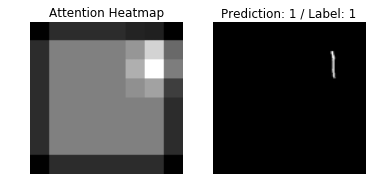

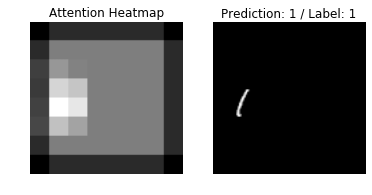

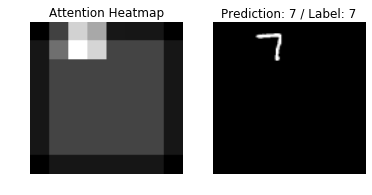

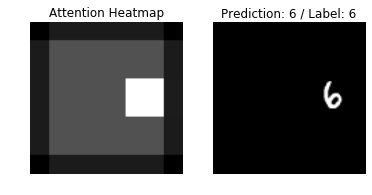

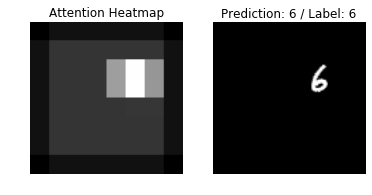

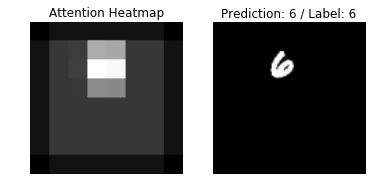

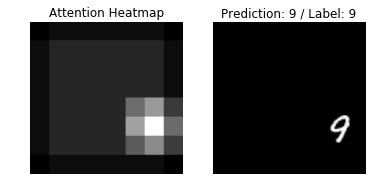

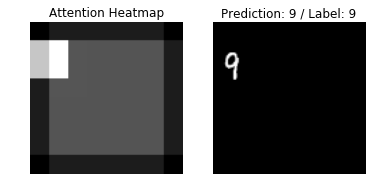

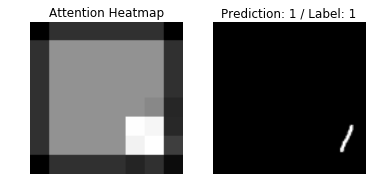

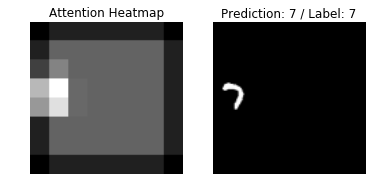

Sample Accuracy: 1.0


In [12]:
# Sampling test indexes
idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_fraction_size, img_fraction_size, len_stack])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Making test fractions
    index_fraction = 0
    for m in range(len_vertical):
        start_v = stride * m
        for n in range(len_horizontal):
            start_h = stride * n

            test_fraction[idx_sample,:,:,index_fraction] = test_x[idx[idx_sample], 
                                                                  start_v : start_v + img_fraction_size, 
                                                                  start_h : start_h + img_fraction_size]

            index_fraction += 1

    # Get alpha(weight of fractions) and output for sample test data
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_fraction[idx_sample,:,:,:]], y_target: [test_y[idx[idx_sample],:]]})
    alpha_reshape = np.reshape(alpha_, (1, len_vertical, len_horizontal))
    
    # Make heatmap with alpha
    for i in range(len_vertical):
        for j in range(len_horizontal):
            heat_map[idx_sample, stride * i : (stride * i + img_fraction_size), stride * j : (stride * j + img_fraction_size)] += alpha_reshape[:, i, j]

    heat_map[idx_sample,:,:] = heat_map[idx_sample,:,:] / np.max(heat_map[idx_sample,:,:])

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx[idx_sample], :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(heat_map[idx_sample,:,:], cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(test_x[idx[idx_sample],:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))